### Kardinya Shale Isopachs

In [136]:
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb


Modelling routines loaded!
Meshing routines loaded!
Plotting routines loaded!


#### Model boundary

In [137]:
x0, x1, y0, y1 = 343000, 420000, 6380000, 6620000

box_coords = [[x0, y0], [x0, y1], [x1, y1], [x1, y0], [x0, y0]]
box_geom = Polygon(box_coords)
box_poly = gpd.GeoDataFrame(index=[0], crs='epsg:28350', geometry=[box_geom])       
box_poly.to_file(filename='../shp/box.shp', driver="ESRI Shapefile")
box = gpd.read_file('../shp/box.shp')
box.to_crs(epsg=28350, inplace=True)
box = resample_poly(box, 1500) 
type(box)

shapely.geometry.polygon.Polygon

#### Import bore data

In [138]:
bore_df = pd.read_excel('../data/Dwer_data/Formation picks.xls', sheet_name = 'bore_info')
bore_gdf = gpd.GeoDataFrame(bore_df, geometry=gpd.points_from_xy(bore_df.Easting, bore_df.Northing), crs="epsg:28350")
data = gpd.clip(bore_gdf, box)
data = data.reset_index(drop = True)
bore_IDs = list(data.ID)
xy = list(zip(data.Easting, data.Northing))

#### Import fault shp

In [139]:
bada = gpd.read_file('../shp/badaminna_trace.shp')
bada.to_crs(epsg=28350, inplace=True)
bada = gpd.clip(bada, box)

PRAMS_faults = gpd.read_file('../shp/PRAMS35_faults.shp')
PRAMS_faults.to_crs(epsg=28350, inplace=True)
PRAMS_faults = gpd.clip(PRAMS_faults, box)

tectonics = gpd.read_file('../shp/500k_tectonicp17.shp')
tectonics.to_crs(epsg=28350, inplace=True)
tectonics = gpd.clip(tectonics, box)

coast = gpd.read_file('../shp/Coastline_LGATE_070.shp')
coast.to_crs(epsg=28350, inplace=True)
coast = gpd.clip(coast, box)

In [140]:
#data

#### Plot of spatial inputs

(6460000.0, 6580000.0)

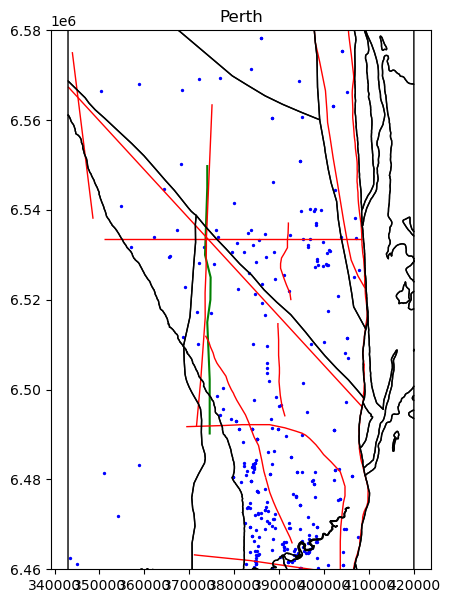

In [141]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_aspect('equal')
data.plot(ax=ax, zorder=2, markersize = 2, color = 'blue')
bada.plot(ax=ax, zorder=2, color = 'green')
PRAMS_faults.plot(ax=ax, lw = 1, color = 'red', zorder=2)
tectonics.boundary.plot(ax=ax, lw = 1, color = 'black', zorder=2)
#for x, y, label in zip(data.geometry.x, data.geometry.y, data.ID):
#    ax.annotate(label, xy=(x, y), xytext=(0.5, 0.5), textcoords="offset points")

ax.set_title('Perth')
ax.set_ylim([6460000, 6580000])

#### Manipulating raw data to extract Kcok isopachs

In [142]:
df = data.copy()
headings = df.columns.values.tolist()
df.Easting = pd.to_numeric(df.Easting)    # Make sure Eastings and Northings are numeric values
df.Northing = pd.to_numeric(df.Northing)
df.Ground = pd.to_numeric(df.Ground)

data_list = df.values.tolist()  # Turn data into a list of lists
Kcok_data = []

for i in range(len(data_list)): #iterate for each row
    easting     = data_list[i][0]
    northing    = data_list[i][1]
    source      = data_list[i][2]
    boreid      = data_list[i][3]
    groundlevel = data_list[i][4]  
    
    Kcok_present = False         # Flag for Kcok absence/presence
    Kcok_zerothickness = False   # Flag for Kcok zero thickness (i.e. bypassed in sequence)
    
    count = 1                               # Add data row for each lithology
    for j in range(5,df.shape[1]-1):        # iterate through each formation 
                        
        if isinstance(data_list[i][j], numbers.Number) == True:  
            bottom = groundlevel - float(data_list[i][j])  # Ground surface - formation bottom (mbgl)
            if headings[j] == 'Kcok':
                thickness = current_bottom - bottom
                if np.isnan(thickness) == False: # Nan returned if space instead of '-' used
                    Kcok_data.append([boreid, easting, northing, thickness, bottom])   
                    Kcok_present = True # Flag to say it is present
            if j > 15 and Kcok_present == False and Kcok_zerothickness == False: # Checks if a deeper formation and no Kcok - put thickness to 0
                Kcok_data.append([boreid, easting, northing, 0., np.nan]) 
                Kcok_zerothickness = True # Flag to say appended as a zero thickness (so won't do it again)
            current_bottom = np.copy(bottom)    
        count+=1

In [143]:
ids, X, Y, dz, bottom = list(zip(*Kcok_data))
#Kcok_data

#### Contouring isopachs

In [150]:
xi = np.arange(x0, x1, 50) # interpolate to 50 x 50m grid
yi = np.arange(y0, y1, 50)
Xi, Yi = np.meshgrid(xi, yi)
z = dz # thickness (m)

# Scipy interpolation
from scipy.interpolate import griddata
zi = griddata((X, Y), z, (xi[None, :], yi[:, None]), method='linear') #'nearest', 'cubic', 'linear'

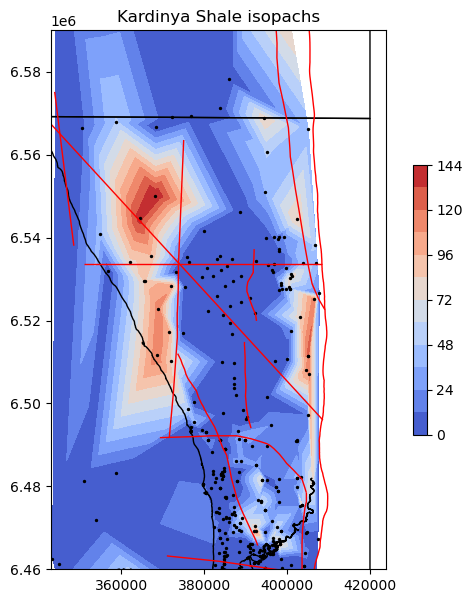

In [156]:
levels = np.arange(0, max(dz), 12)

fig, ax = plt.subplots(figsize = (7,7))
ax.set_aspect('equal')
ax.set_title('Kardinya Shale isopachs')
#ax.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, zi, levels=levels, cmap="coolwarm")
coast.boundary.plot(ax=ax, lw = 1, color = 'black', zorder=2)
PRAMS_faults.plot(ax=ax, lw = 1, color = 'red', zorder=2)
ax.scatter(X, Y, color = 'black', s = 2)
#for x, y, label in zip(data.geometry.x, data.geometry.y, data.ID):
#    ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
ax.set_ylim([6460000, 6590000])
fig.colorbar(cntr, shrink = 0.5, ax=ax)

plt.show()

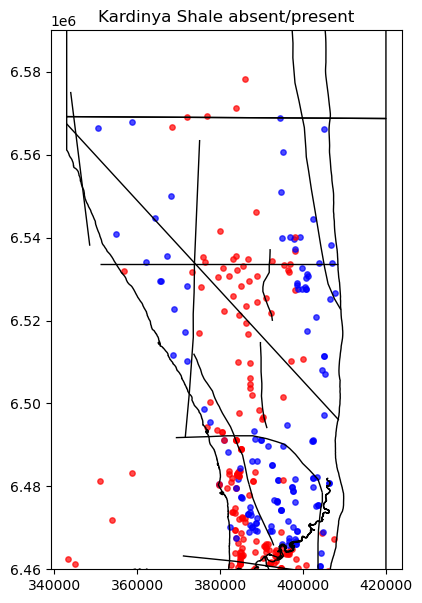

In [146]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_aspect('equal')
ax.set_title('Kardinya Shale absent/present')
for i in Kcok_data:
    if i[3] == 0.:
        ax.scatter(i[1], i[2], s = 15, alpha = 0.7, color = 'red') # Absent
    else:
        ax.scatter(i[1], i[2], s = 15, alpha = 0.7, color = 'blue') # Present
coast.boundary.plot(ax=ax, lw = 1, color = 'black', zorder=2)
PRAMS_faults.plot(ax=ax, lw = 1, color = 'black', zorder=2)
ax.set_ylim([6460000, 6590000])
plt.show()

#### Kardinya Shale - bottom of formation (where present)

In [147]:
xi = np.arange(x0, x1, 50) # interpolate to 50 x 50m grid
yi = np.arange(y0, y1, 50)
Xi, Yi = np.meshgrid(xi, yi)
z = bottom # thickness (m)

# Scipy interpolation
from scipy.interpolate import griddata
zi = griddata((X, Y), z, (xi[None, :], yi[:, None]), method='linear') #'nearest', 'cubic', 'linear'

#levels = [0, 1, 2, 5, 10, 15, 20, 50, 75, 100, 150]

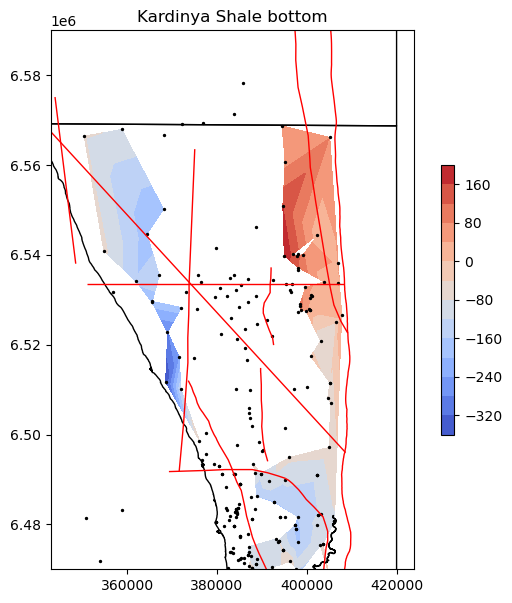

In [148]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_aspect('equal')
ax.set_title('Kardinya Shale bottom')
#ax.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, zi, levels=14, cmap="coolwarm")
coast.boundary.plot(ax=ax, lw = 1, color = 'black', zorder=2)
PRAMS_faults.plot(ax=ax, lw = 1, color = 'red', zorder=2)
ax.scatter(X, Y, color = 'black', s = 2)
#for x, y, label in zip(data.geometry.x, data.geometry.y, data.ID):
#    ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
ax.set_ylim([6470000, 6590000])
fig.colorbar(cntr, shrink = 0.5, ax=ax)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [125]:
Kcok_data

[['AM57', 380392.0, 6417422.0, 0.0, nan],
 ['AM54', 381972.0, 6426982.0, 0.0, nan],
 ['Pe1', 352893.0, 6427632.0, 0.0, nan],
 ['AM52Z', 376115.0, 6433422.0, 37.0, -219.0],
 ['AM52Y', 374326.0, 6441206.0, 130.0, -158.0],
 ['THE_ESPLANADE_ART', 381662.0, 6452439.0, 0.0, nan],
 ['AM67', 382835.0, 6402182.0, 0.0, nan],
 ['AM52', 383439.0, 6434823.0, 0.0, nan],
 ['AM71', 383534.3, 6444114.6, 0.0, nan],
 ['WPSIM01', 383534.0, 6444126.9, 0.0, nan],
 ['FREMANTLE_SAILING_CLUB', 382059.0, 6451272.0, 0.0, nan],
 ['HAMPTON_ROAD_ART_NO_2', 382420.0, 6452909.0, 0.0, nan],
 ['fremantle_LCG1', 382284.0, 6453440.0, 0.0, nan],
 ['Bicton_Pool_G1',
  384500.0,
  6455733.0,
  81.60000210000001,
  -120.21004803512575],
 ['MPOOL', 384500.0, 6455733.0, 82.0, -123.0],
 ['IF5', 384132.0, 6456291.0, 0.0, nan],
 ['IF_4', 382955.0, 6456367.0, 0.0, nan],
 ['SHG1', 383526.0, 6458302.0, 50.2000203, -98.48750352587899],
 ['I_F_2', 382086.0, 6458417.0, 0.0, nan],
 ['IF_16', 382886.0, 6458534.0, 0.0, nan],
 ['IF6', 3840